In [1]:
# ==================================================
# 0. 의존성
# ==================================================
import torch, numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NORMAL_DIGITS   = list(range(1,10))   # 1–9 = 정상
ANOMALY_DIGIT   = 0                   # 0   = 이상
BATCH_SIZE      = 16
EPOCHS          = 20
TH_PCT          = 95                  # 재구성 오차 임계치 (상위 5 %)


In [2]:
# ==================================================
# 1. 데이터 (train: 정상만 / test: 전체)
# ==================================================
tf = transforms.ToTensor()
mnist_tr = datasets.MNIST("mnist", train=True,  download=True, transform=tf)
mnist_te = datasets.MNIST("mnist", train=False, download=True, transform=tf)

tr_idx = [i for i,(_,y) in enumerate(mnist_tr) if y in NORMAL_DIGITS]
train_loader = DataLoader(Subset(mnist_tr, tr_idx), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(mnist_te, batch_size=BATCH_SIZE, shuffle=False)


In [3]:
# ==================================================
# 2. 오토인코더 정의
# ==================================================
LATENT_DIM = 4

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, LATENT_DIM)
        )
    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(LATENT_DIM, 32 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),
            # 중요: 출력 픽셀 값을 [0, 1] 범위로 맞춰주기 위해 Sigmoid 추가
            nn.Sigmoid()
        )
    def forward(self, z):
        z = self.fc(z).view(-1, 32, 7, 7)
        return self.deconv(z)

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc, self.dec = Encoder(), Decoder()
    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion  = nn.MSELoss(reduction="none")   # 픽셀별 오차 계산용

In [4]:
# ==================================================
# 3. 학습
# ==================================================
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for x,_ in train_loader:
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x).mean()   # 배치 평균
        loss.backward(); optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    print(f"[{epoch+1:02}/{EPOCHS}] Train-MSE = {epoch_loss/len(train_loader.dataset):.4f}")


[01/20] Train-MSE = 0.0443
[02/20] Train-MSE = 0.0359
[03/20] Train-MSE = 0.0344
[04/20] Train-MSE = 0.0336
[05/20] Train-MSE = 0.0331
[06/20] Train-MSE = 0.0327
[07/20] Train-MSE = 0.0324
[08/20] Train-MSE = 0.0321
[09/20] Train-MSE = 0.0319
[10/20] Train-MSE = 0.0318
[11/20] Train-MSE = 0.0316
[12/20] Train-MSE = 0.0315
[13/20] Train-MSE = 0.0314
[14/20] Train-MSE = 0.0313
[15/20] Train-MSE = 0.0312
[16/20] Train-MSE = 0.0311
[17/20] Train-MSE = 0.0310
[18/20] Train-MSE = 0.0309
[19/20] Train-MSE = 0.0309
[20/20] Train-MSE = 0.0308


In [5]:
# ==================================================
# 4. 임계치 계산 (train 재구성 오차 95 %)
# ==================================================
model.eval(); train_scores = []
with torch.no_grad():
    for x,_ in train_loader:
        x = x.to(DEVICE)
        x_hat = model(x)
        # 배치별 샘플 오차 (N,)  = 각 이미지의 평균 픽셀 MSE
        batch_err = criterion(x_hat, x).view(x.size(0), -1).mean(1)
        train_scores.append(batch_err.cpu())
train_scores = torch.cat(train_scores)
THRESHOLD = torch.quantile(train_scores, TH_PCT/100).item()
print(f"\n[Threshold] {TH_PCT}% percentile of train-error → {THRESHOLD:.6f}")



[Threshold] 95% percentile of train-error → 0.060382


In [6]:
# ==================================================
# 5. 테스트 평가 (재구성 오차)
# ==================================================
y_true, y_score = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        recon = model(x)
        err   = criterion(recon, x).view(x.size(0), -1).mean(1).cpu()
        y_score.extend(err.numpy())
        y_true.extend((y == ANOMALY_DIGIT).int().numpy())

auc = roc_auc_score(y_true, y_score)
y_pred = (np.array(y_score) > THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f"\n[Test] ROC-AUC = {auc:.4f}")
print(f"Confusion @ TH={THRESHOLD:.6f}  →  TP={tp}, FP={fp}, TN={tn}, FN={fn}")



[Test] ROC-AUC = 0.9389
Confusion @ TH=0.060382  →  TP=584, FP=486, TN=8534, FN=396


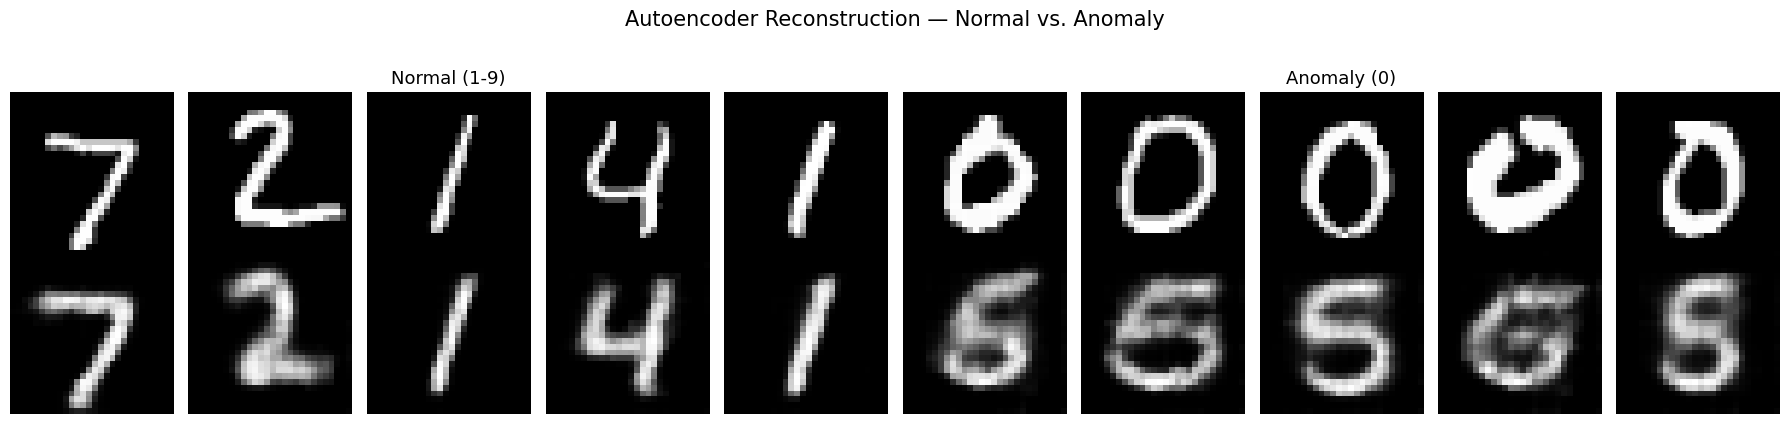

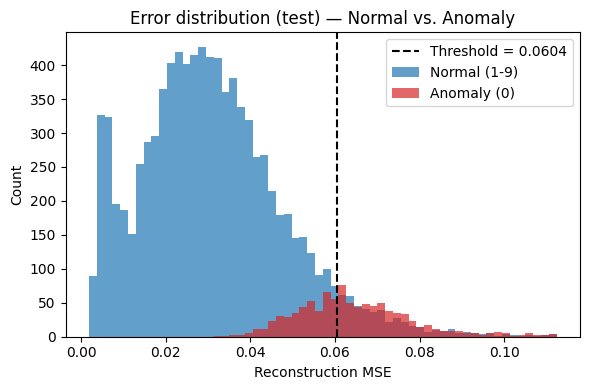

In [7]:
# ==================================================
# 6. 간단 시각화  (입력 · 재구성 & 오차 분포)
# ==================================================
# ---------------------------------------------
# 6-1. 입력 / 재구성 시각화 (subplot 버전)
# ---------------------------------------------
import matplotlib.pyplot as plt

model.eval()
norm_pairs, anom_pairs = [], []        # (input, recon) 튜플 모음

with torch.no_grad():
    for x, y in test_loader:
        for img, label in zip(x, y):
            recon = model(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
            pair  = (img.cpu(), recon)
            if label == ANOMALY_DIGIT:
                if len(anom_pairs) < 5:
                    anom_pairs.append(pair)
            else:
                if len(norm_pairs) < 5:
                    norm_pairs.append(pair)
        if len(norm_pairs) == 5 and len(anom_pairs) == 5:
            break

samples = norm_pairs + anom_pairs      # 5 + 5 = 10 열
fig, axes = plt.subplots(2, 10, figsize=(18, 4))

for col, (inp, rec) in enumerate(samples):
    # 행 0 → Input
    axes[0, col].imshow(inp.squeeze(), cmap="gray")
    axes[0, col].axis("off")
    # 행 1 → Reconstruction
    axes[1, col].imshow(rec.squeeze(), cmap="gray")
    axes[1, col].axis("off")

# 레이블·제목
axes[0, 0].set_ylabel("Input",  fontsize=12)
axes[1, 0].set_ylabel("Recon",  fontsize=12)
axes[0, 2].set_title("Normal (1-9)", fontsize=13)    # 0–4 열
axes[0, 7].set_title("Anomaly (0)",  fontsize=13)    # 5–9 열
plt.suptitle("Autoencoder Reconstruction — Normal vs. Anomaly", y=1.05, fontsize=15)
plt.tight_layout()
plt.show()

# 6-2. 오차 히스토그램 — 정상 vs. 이상 색상 구분
err_tensor  = torch.tensor(y_score)
label_tensor = torch.tensor(y_true)        # 0=정상, 1=이상

err_norm = err_tensor[label_tensor == 0]   # 정상  (digits 1-9)
err_anom = err_tensor[label_tensor == 1]   # 이상  (digit 0)

bins = 60
hist_norm, edges = torch.histogram(err_norm, bins=bins)
hist_anom, _     = torch.histogram(err_anom, bins=edges)  # 동일 bin 사용
centers = (edges[:-1] + edges[1:]) / 2
width   = centers[1] - centers[0]

plt.figure(figsize=(6, 4))
plt.bar(centers.numpy(), hist_norm.numpy(),
        width=width, color="#1f77b4", alpha=0.7, label="Normal (1-9)")
plt.bar(centers.numpy(), hist_anom.numpy(),
        width=width, color="#d62728", alpha=0.7, label="Anomaly (0)")
plt.axvline(THRESHOLD, linestyle="--", color="k", label=f"Threshold = {THRESHOLD:.4f}")
plt.xlabel("Reconstruction MSE")
plt.ylabel("Count")
plt.title("Error distribution (test) — Normal vs. Anomaly")
plt.legend()
plt.tight_layout()
plt.show()